# **The Stokes equations**
**Johan Hoffman**

Edits performed by Teo Nordström

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

In addition to what was already in the template, some assignments in the code have been completed. This includes creating an unstable equal order interpolation implementation, and including a reverse flow state for the Taylor-Hood Mixed Element implementation. Discussion around these have also been included.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [49]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [50]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v)
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q)
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$.

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero.

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces,
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition.


# **Method**

**Define domain and mesh**

The changes that were done to change the domain into a channel with only one circular hole were done in a new mesh variable, with the old ones commented out. All that is done is creating a rectangle of the channel size $H*L$, from which we subtract a circle of r=1 at $0.5*H$ and $0.5*L$. To refine this we use the for loop included in the template. We set the times for this loop to run to 1, and change the point from which the loop tests distance from to the same point as the center of the circle. We check if the distance is less than 1, which would mean that it is within a circle of radius 1 around the circular hole's center.

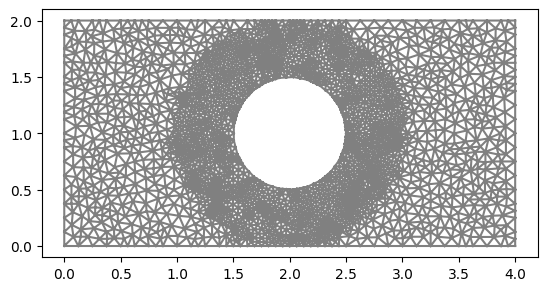

In [51]:
# Define rectangular domain
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32 # h = 1 / resolution
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5,0.5*H),0.2), resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.5), resolution) # Mesh with circle of r=0.5 in middle

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

To show that the Taylor-Hood mixed element is stable while the equal order interpolation isn't, we implement a linear interpolation for the velocity in variable VE. This goes together with the linear pressure which gives us an equall order interpolation. The Taylor-Hood mixed element is already implemented with velocity of the second order combined with pressure of the first order. We also add a new set of functions that are identical to the Taylor-Hood mixed element functions, but that are to be used with reversed flow.

In [52]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

VEL = VectorElement("CG", mesh.ufl_cell(), 1)
WEL = VEL * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

WL = FunctionSpace(mesh, WEL)
VL = FunctionSpace(mesh, VEL)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

# Define functions for Linear in both cases
wl = Function(WL)
(ul, pl) = (as_vector((wl[0], wl[1])), wl[2])
(vl, ql) = TestFunctions(WL)

# Define functions for reverse flow
wr = Function(W)
(ur, pr) = (as_vector((wr[0],wr[1])), wr[2])
(vr, qr) = TestFunctions(W)

**Define boundary conditions**

An inflow condition for the equal order implementation was added, the boundaries only interact with the pressure which has not been changed for this.

In [53]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
uinl = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = VL.ufl_element())
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

**Define reverse flow boundary conditions**

We will also define a flow where the inflow is from the right and outflow towards the left to see how this affects pressure. We will use the same wall boundary. We also don't have to make a new ob, since it is not used in the code anyways.

In [54]:
uinr = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ibr = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problem**

Taylor-Hood Mixed Element

In [55]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx +
            gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system
solve(residual == 0, w)

Equal Order Implementation

In [56]:
fl = Expression(("0.0","0.0"), element = VL.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
lin_residual = ( - pl*div(vl)*dx + inner(grad(ul), grad(vl))*dx + div(ul)*ql*dx +
            gamma*(ib*inner(ul - uinl, vl) + wb*inner(ul, vl))*ds - inner(fl, vl)*dx )

# Solve algebraic system
solve(lin_residual == 0, wl)

Reverse Flow

In [57]:
fr = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
rev_residual = ( - pr*div(v)*dx + inner(grad(ur), grad(vr))*dx + div(ur)*qr*dx +
            gamma*(ibr*inner(ur - uinr, vr) + wb*inner(ur, vr))*ds - inner(fr, vr)*dx )

# Solve algebraic system
solve(rev_residual == 0, wr)

**Visualize solution and export files**

Taylor-Hood Mixed Element

In [58]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")

u1 = project(u, V)
p1 = project(p, Q)

# Save solution to file
file_u << u1
file_p << p1

rm: cannot remove 'results-NS/*': No such file or directory


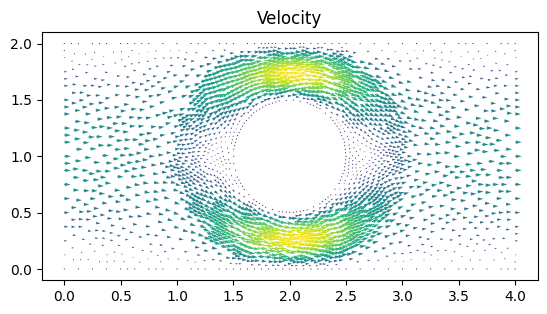

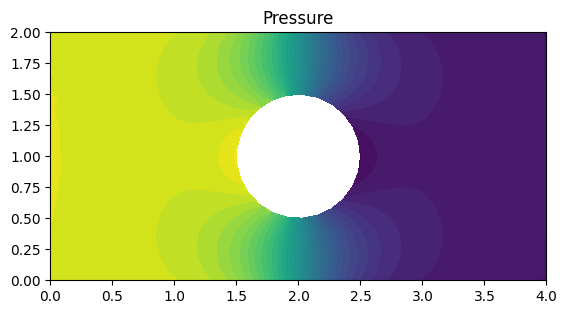

In [59]:
# Plot solution
plt.figure()
plot(u1, title="Velocity")

plt.figure()
plot(p1, title="Pressure")

plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

Equal Order Implementation

In [60]:
# Open files to export solution to Paraview
file_ul = File("results-Stokes/ul.pvd")
file_pl = File("results-Etokes/pl.pvd")

u2 = project(ul, VL)
p2 = project(pl, Q)

# Save solution to file
file_ul << u2
file_pl << p2

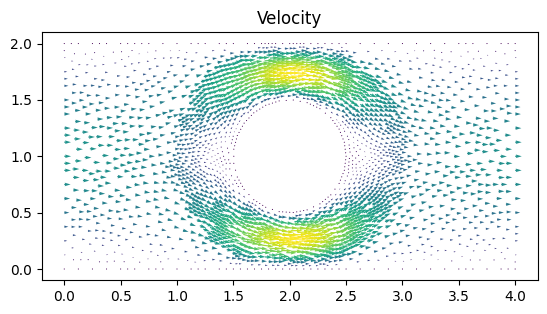

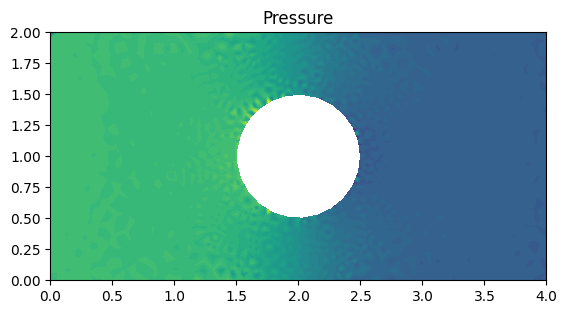

In [61]:
# Plot solution
plt.figure()
plot(u2, title="Velocity")

plt.figure()
plot(p2, title="Pressure")

plt.show()

Reverse Flow

In [62]:
# Open files to export solution to Paraview
file_ur = File("results-Stokes/ur.pvd")
file_pr = File("results-Etokes/pr.pvd")

u3 = project(ur, VL)
p3 = project(pr, Q)

# Save solution to file
file_ur << u3
file_pr << p3

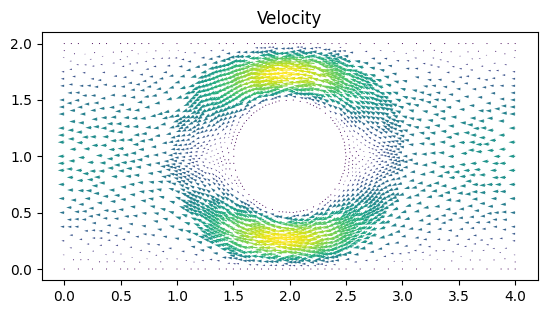

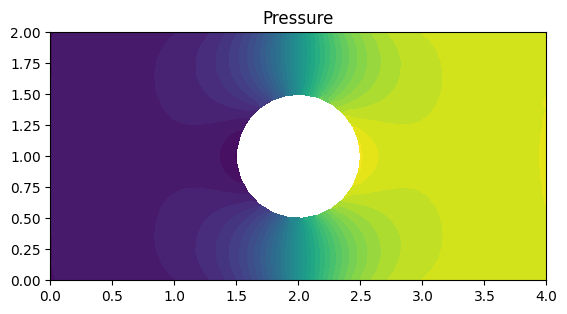

In [63]:
# Plot solution
plt.figure()
plot(u3, title="Velocity")

plt.figure()
plot(p3, title="Pressure")

plt.show()

# **Discussion**

A Taylor-Hood mixed finite element method was implemented in FEniCS to solve the Stokes equations in 2D. The method was tested for the model problem of flow past a central circular obstacle, and the solution behaved as expected. An Equal Order Interpolation was also tested in the same finite element method, where we can see that the pressure is oscillating which does not follow established physics phenomena.   

**Stability of Taylor-Hood Mixed Element and the Equal Order Interpolation**

From the plots above we can see the velocity and pressure exterted by the two different finite element spaces. When looking at them we can see that the velocity looks essentially identical, but if we inspect the pressure graph we can see a big difference. Looking at the Taylor-Hood pressure graph we see expected phenomena: a symmetric pressure development around the circle with high pressure before the inflow gets past the circle. We can see how the pressure builds up on the left face of the circle since that is where we get the strain flow. The pressure then loosens on the right side since there is nothing stopping it from flowing out the right boundary. This verifies for us that the Taylor-Hood Mixed Element gives us a stable result.

However, when we use equal order interpolation we can se that the pressure graph doesnt look very correct. While the left side still is higher pressure than the right, we can see that the pressure is very "dotty". It is oscillating in points in a way that would not be physical. Since we only have one consistent flow from the right this kind of interrupted pressure would be impossible, and this is how the instability manifests itself. This means that the equal order interpolation does not give us a usable result.

**Reverse Flow**

By switching the inflow and outflow boundaries and inverting the inflow condition we have gotten a flow that goes from right to left. Since we are using the same Taylor-Hood Mixed Element as the first attempt moving from left to right we can verify that this is working correctly, since the graph looks essentially identical, just flipped on the x axis. This is since the circle the fluid must move around is in the exact middle of the graph, leaving no room for differences.